<a href="https://colab.research.google.com/github/larissamacb/7DaysOfCode-Linkedin/blob/main/Analise_do_NSL_KDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos do Dataset e do Treino

Primeiro precisamos conhecer os nossos dados. Naturalmente, eles mostram diversas características (40* atributos) relacionadas a um ataque cibernético específico (ou a uma situação normal). É mais comum então que se use este modelo para dois propósitos de treino:

*   **Identificar se um tráfego é um ataque ou não –** o que leva a melhores resultados, devido ao comparativo de 67.343 amostras classificadas como “normal” para as 58.630 classificadas como algum ataque no dataset de treino.
*   **Identificar se é um tráfego normal ou uma categoria de ataque específica, trazendo também a categoria –** Uma tarefa muito mais difícil, uma vez que os dados estão muito desbalanceados nas categorias, mas que, em um cenário real, pode se tornar uma informação valiosa para que o ataque seja contido com mais facilidade.

> *Apesar de existirem 42 colunas, uma é a classificação do ataque (`label`) e outra é a dificuldade de se classificá-lo corretamente (`difficulty`), que além de não ter relação com o ataque em si, pode treinar o modelo com uma informação “desonesta”.




Podemos então seguir o segundo propósito para fazer uma análise inicial e entender os ataques e suas características comuns. Os tipos de ataques englobados são:

---

### DoS (Denial of Service)
* **Descrição:** um ataque que busca sobrecarregar o alvo, o levando a “negar o serviço” para outros usuários legítimos, como o nome sugere. Ele fere a disponibilidade de um serviço, seja por Inundação de Volume, enviando uma quantidade absurda de tráfego para saturar a largura de banda da rede do alvo, ou por Inundação de Conexão, enviando um grande número de solicitações de conexão parciais ou malformadas, forçando o alvo a alocar recursos para conexões "fantasmas" que nunca são concluídas, levando à exaustão da sua tabela de estado.
* **Impressão Digital:** tráfego extremamente alto, repetitivo, de curta duração e com uma taxa de erro gigantesca (pois as conexões propositalmente nunca são completadas).
* **Presentes no dataset:** `“back”, “land”, “neptune”, “pod”, “smurf”, “teardrop”, “mailbomb”, “apache2”, “processtable”, “udpstorm”.`

---

### Probe (Sondagem)
* **Descrição:** tráfego de reconhecimento usado para mapear uma rede e identificar alvos vulneráveis, visando a coleta de informações. Inclui:
    * **Varredura de Portas/Serviços:** Envio sistemático de pacotes para uma gama de portas em um ou mais hosts para determinar quais serviços estão ativos.
    * **Varredura de Rede:** identificação de quais hosts estão ativos em um segmento de rede (ex: varreduras ICMP).
* **Impressão Digital:** caracteriza-se por um padrão de "um para muitos" (um atacante para muitas portas/hosts) ou "muitos para um" (vários atacantes para um alvo). O tráfego é amplo e superficial, com conexões breves a diversos serviços distintos.
* **Presentes no dataset:** `“ipsweep”, “nmap”, “portsweep”, “satan”, “mscan”, “saint”.`

---

### R2L (Remote to Local - Acesso Remoto)
* **Descrição:** tráfego que representa uma tentativa de um atacante externo obter acesso não autorizado (uma conta de usuário) em uma máquina local. Esta é a fase de exploração remota. Inclui tentativas de força bruta de senhas (ex: em FTP, SSH), exploração de vulnerabilidades em serviços de rede (ex: buffer overflows em um servidor web) ou engenharia social.
* **Impressão Digital:** geralmente é um tráfego sutil e focado em um único serviço. Pode ser identificado por múltiplas tentativas de login falhas, a transferência de payloads de exploit ou interações de dados anômalas após o estabelecimento de uma conexão.
* **Presentes no dataset:** `“ftp_write”, “guess_passwd”, “imap”, “multihop”, “phf”, “spy”, “warezclient”, “warezmaster”, “sendmail”, “named”, “snmpgetattack”, “snmpguess”, “xlock”, “xsnoop”, “worm”.`

---

### U2R (User to Root - Escalação de Privilégios)
* **Description:** tráfego que se origina de um atacante que já possui acesso como um usuário comum (local) na máquina alvo. O objetivo é explorar uma vulnerabilidade interna do sistema para obter privilégios de administrador (root).
* **Impressão Digital:** este é o tráfego mais difícil de detectar, pois se origina "de dentro". É caracterizado por um usuário legítimo executando ações altamente anômalas, como acessar ou modificar arquivos de configuração do sistema, tentar executar comandos de depuração ou interagir com o kernel do sistema de formas não-padrão.
* **Presentes no dataset:** `“buffer_overflow”, “loadmodule”, “perl”, “rootkit”, “httptunnel”, “ps”, “sqlattack”, “xterm”.`

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

In [ ]:
# Formata os floats
pd.set_option('display.float_format', '{:.6f}'.format)

# ----- Preparação dos DataFrames: nomeação de colunas e categorização dos ataques -----

# Nomes das Colunas
colunas = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

# Carregamento dos dados
df_train_raw = pd.read_csv('KDDTrain+.txt', header=None, names=colunas)
df_test_raw = pd.read_csv('KDDTest+.txt', header=None, names=colunas)

# Mapeamento dos ataques por categoria
attack_map = {
    'normal': 'normal',
    'back': 'dos', 'land': 'dos', 'neptune': 'dos', 'pod': 'dos', 'smurf': 'dos', 'teardrop': 'dos',
    'mailbomb': 'dos', 'apache2': 'dos', 'processtable': 'dos', 'udpstorm': 'dos',
    'ipsweep': 'probe', 'nmap': 'probe', 'portsweep': 'probe', 'satan': 'probe',
    'mscan': 'probe', 'saint': 'probe',
    'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'multihop': 'r2l', 'phf': 'r2l',
    'spy': 'r2l', 'warezclient': 'r2l', 'warezmaster': 'r2l', 'sendmail': 'r2l', 'named': 'r2l',
    'snmpgetattack': 'r2l', 'snmpguess': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l', 'worm': 'r2l',
    'buffer_overflow': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r', 'rootkit': 'u2r',
    'httptunnel': 'u2r', 'ps': 'u2r', 'sqlattack': 'u2r', 'xterm': 'u2r'
}

# Substituição do nome do ataque por sua categoria
df_train_raw['attack_type'] = df_train_raw['label'].apply(lambda x: attack_map.get(x, 'unknown'))
df_test_raw['attack_type'] = df_test_raw['label'].apply(lambda x: attack_map.get(x, 'unknown'))

print("\nDistribuição de Classes (Treino):")
print(df_train_raw['attack_type'].value_counts())

print("\nDistribuição de Classes (Teste):")
print(df_test_raw['attack_type'].value_counts())


Distribuição de Classes (Treino):
attack_type
normal    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64

Distribuição de Classes (Teste):
attack_type
normal    9711
dos       7458
r2l       2754
probe     2421
u2r        200
Name: count, dtype: int64


# Os Padrões de Ataque

Como vimos, essas categorias de ataque são fortemente caracterizadas. Portanto, poderia ser intuitivo classificar os ataques com base nas suas features. Por exemplo, para um ataque de DoS, esperamos uma taxa de erros alta (atributo `serror_rate`) proveniente de diversas tentativas de conexão incompletas, enquanto que a maioria das flags (atributo `flag`) será S0 pelo mesmo motivo, indicando que o houve um início de conexão por meio de um SYN, mas que o SYN ACK do servidor alvo nunca foi respondido.

Entretanto, com tantos atributos e tantos números, não é fácil para um ser humano fazer essa análise para tantas amostras e com a velocidade necessária. É por isso que se usa um modelo de machine learning para identificar esses padrões rapidamente. A questão é que, se já temos uma noção de quais são os padrões, podemos facilitar o trabalho da inteligência artificial tentando os apontar para ela.
#
----
#
Aqui entra o conceito de **Feature Engineering**, que com esse objetivo, consiste em criar novas colunas no dataset com base em outras. Podemos aplicá-lo no NSL-KDD, criando colunas que sirvam como “dicas” para o modelo. No nosso caso, podem ser dicas diretas da probabilidade de uma amostra ser um ataque de DoS, Probe, R2L ou U2R a partir de um cálculo que demonstre a influência das **features de maior importância** para cada um deles.

Podemos encontrar essas features visualmente, Por meio de um heatmap, conseguimos criar um **“perfil de ameaça”** para os quatro tipos de ataques. Isso pode ser feito por meio de uma comparação da média de valor para um atributo de cada ataque em relação à média das amostras “normais”.


# E como fazemos isso?

Primeiro definimos o que é o “normal”. Usando o método *.fit()* do StandardScaler apenas nos dados classificados como “normal”, calculamos a média e o desvio padrão para cada feature do dataset. Depois usamos o método *.transform()* em todo o dataset, aplicando a “régua” aprendida com as amostras que não representavam ataques. Assim podemos entender, para cada valor, como ele está em relação ao valor “normal”. Por exemplo:

* Um valor 0.0 significa "igual à média normal".
* Um valor +3.5 significa "3.5 desvios padrão acima da média normal".
* Um valor -2.1 significa "2.1 desvios padrão abaixo da média normal".

Por fim, para criarmos o heatmap, resumimos os dados calculando a média para cada atributo por ataque. Assim, o número em cada célula do heatmap será a média de todos os Z-Scores (a quantos desvios-padrão um ponto de dado está da média de um conjunto de dados) daquela feature para aquele tipo de ataque.


### Sobre as cores

Na imagem (um pouco abaixo), podemos ter então uma noção da relevância de cada feature com base em sua cor.

* **Cor Branca (Z-Score ~0):** Mostra que naquele ataque, o valor daquela feature não difere muito do tráfego normal.
* **Cor Vermelha (Z-Score Positivo):** Mostra que, em média, aquele ataque tem valores muito acima do normal para aquela feature.
* **Cor Azul (Z-Score Negativo):** Mostra que, em média, aquele ataque tem valores muito abaixo do normal.

# Análise Exploratória dos Dados (EDA)

Lembre-se de que nós juntamos os dados de treino e de teste para fazer a análise visual, mas na etapa de treino, os dados de teste não serão utilizados.

In [ ]:
# ----- Demonstração da caracterização dos ataques por meio de heatmaps -----

# O primeiro passo é a separação das features que serão utilizadas em cada heatmap

df_combined_raw = pd.concat([df_train_raw, df_test_raw], ignore_index=True)

categorical_cols = ['protocol_type', 'service', 'flag']
df_combined_processed = pd.get_dummies(df_combined_raw, columns=categorical_cols)

all_feature_names = df_combined_processed.drop(columns=['label', 'difficulty', 'attack_type']).columns.tolist()

original_numerical_cols = df_train_raw.select_dtypes(include=[np.number]).columns.tolist()
original_numerical_cols.remove('difficulty')

# Separação das colunas categóricas (que originam dummies) para análise em gráficos separados
cols_protocol = [col for col in all_feature_names if col.startswith('protocol_type_')]
cols_service = [col for col in all_feature_names if col.startswith('service_')]
cols_flag = [col for col in all_feature_names if col.startswith('flag_')]

# Identificação das features binárias (0 ou 1) que não são dummies
original_binary_flag_cols = [
    'land', 'logged_in', 'root_shell', 'su_attempted',
    'is_host_login', 'is_guest_login'
    ]

# Quantitativas puras (excluindo as binárias)
original_quantitative_cols = [col for col in original_numerical_cols if col not in original_binary_flag_cols]

print(f"Total de {len(all_feature_names)} features identificadas (incluindo dummies).")
print(f"Numéricas Quantitativas: {len(original_quantitative_cols)}")
print(f"Numéricas Binárias: {len(original_binary_flag_cols)}")
print(f"Dummies de Protocol: {len(cols_protocol)}")
print(f"Dummies de Service: {len(cols_service)}")
print(f"Dummies de Flag: {len(cols_flag)}")

Total de 122 features identificadas (incluindo dummies).
Numéricas Quantitativas: 32
Numéricas Binárias: 6
Dummies de Protocol: 3
Dummies de Service: 70
Dummies de Flag: 11


In [ ]:
# Aqui fazemos o comparativo das amostras de ataque em relação às amostras normais

df_combined_normal_only = df_combined_processed[df_combined_processed['attack_type'] == 'normal']

# Scaling baseado no "normal"
scaler_combined = StandardScaler()
scaler_combined.fit(df_combined_normal_only[original_quantitative_cols]) # Treina só nas quantitativas

# Transforma apenas as quantitativas puras
scaled_combined_quant_data = scaler_combined.transform(df_combined_processed[original_quantitative_cols])
df_combined_scaled_quant = pd.DataFrame(scaled_combined_quant_data, columns=original_quantitative_cols)

# Pega as qualitativas (binárias + dummies) SEM escalar
qualitative_cols_all = original_binary_flag_cols + cols_protocol + cols_service + cols_flag
df_combined_qual = df_combined_processed[qualitative_cols_all].reset_index(drop=True)

# Junta os dois grupos
df_combined_scaled_correct = pd.concat([df_combined_scaled_quant, df_combined_qual], axis=1)
df_combined_scaled_correct['attack_type'] = df_combined_processed['attack_type'].values

heatmap_data_full = df_combined_scaled_correct.groupby('attack_type').mean()

heatmap_data_attacks_only = heatmap_data_full.drop('normal')

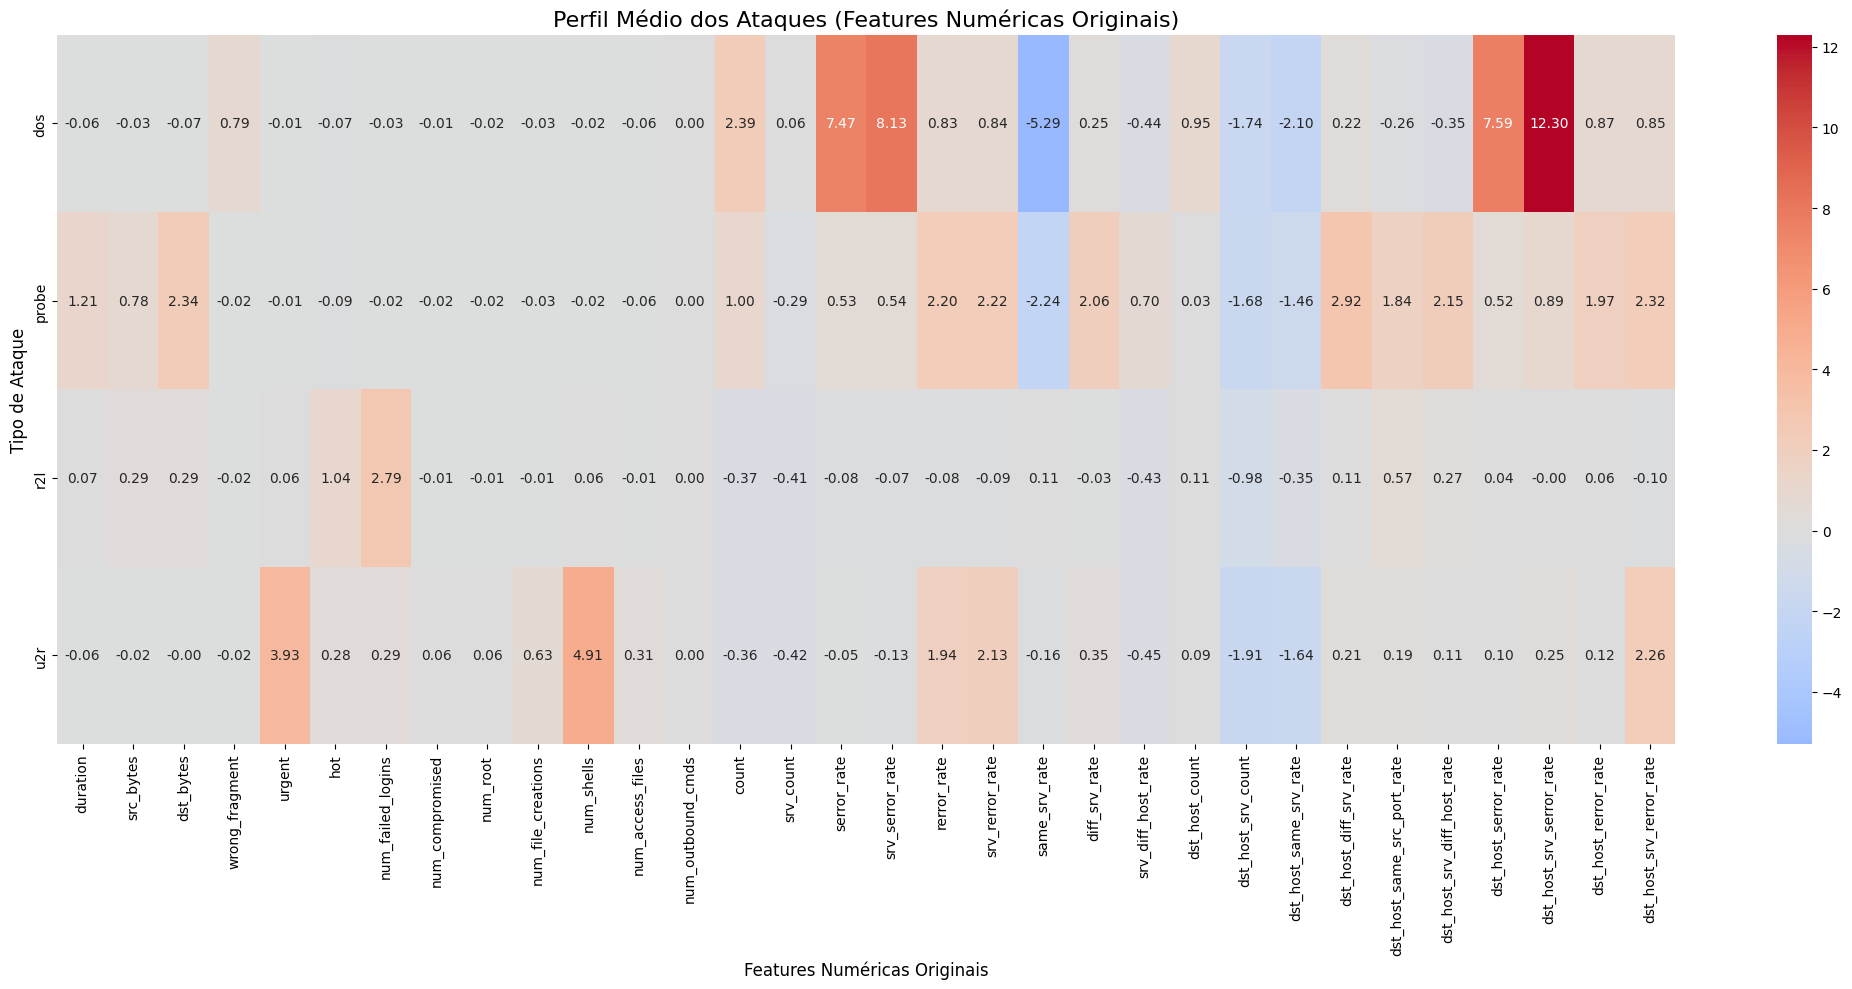

In [ ]:
# ----- Heatmap 1: Features Quantitativas -----

plt.figure(figsize=(21, 10))
sns.heatmap(
    heatmap_data_attacks_only[original_quantitative_cols], # Filtra para as quantitativas
    annot=True, fmt='.2f', cmap='coolwarm', center=0, annot_kws={"size": 10}
)
plt.title('Perfil Médio dos Ataques', fontsize=16)
plt.xlabel('Features Numéricas Originais', fontsize=12)
plt.ylabel('Tipo de Ataque', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Plotando o heatmap para as Features Binárias Originais (Taxa de Ocorrência)...


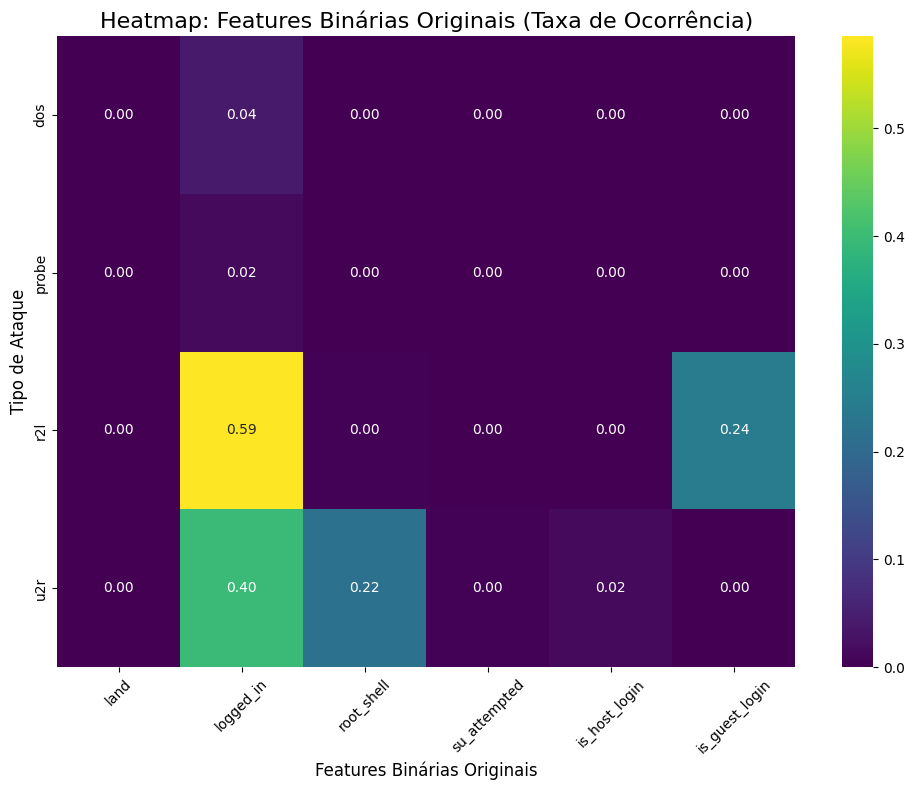

In [ ]:
# --- Heatmap 2: Features Binárias ---

# Aqui se baseia apenas em taxa de ocorrência, não em comparação ao normal

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data_attacks_only[original_binary_flag_cols], # Filtra para as binárias
    annot=True,
    fmt='.2f',       # Mostrar como float
    cmap='viridis',  # Usamos um cmap 'viridis' (0 -> 1) em vez de 'coolwarm' (divergente)
    center=None      # Não há 'centro' aqui, a escala é de 0 a 1
)
plt.title('Heatmap: Features Binárias (Taxa de Ocorrência)', fontsize=16)
plt.xlabel('Features Binárias', fontsize=12)
plt.ylabel('Tipo de Ataque', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

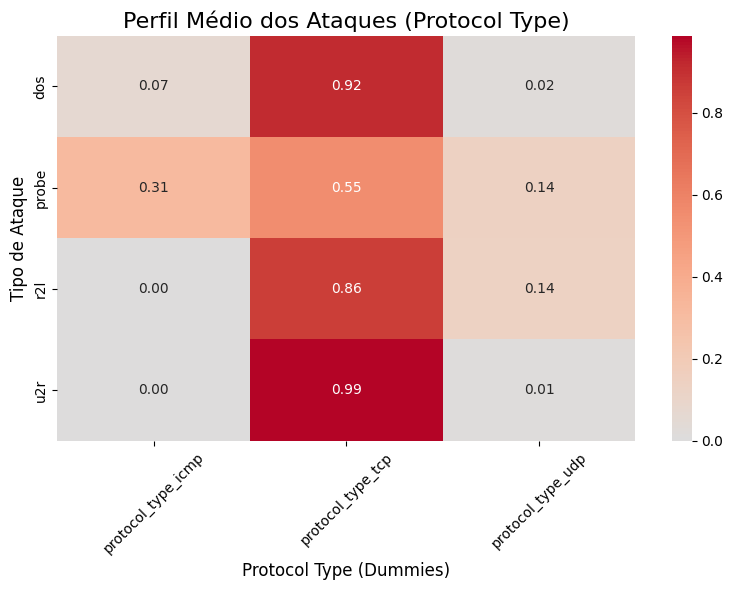

In [ ]:
# --- Heatmap 3: Protocol Type ---

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_attacks_only[cols_protocol], # Filtra para as dummies de protocolo
    annot=True, fmt='.2f', cmap='coolwarm', center=0, annot_kws={"size": 10}
)
plt.title('Perfil Médio dos Ataques (Protocol Type)', fontsize=16)
plt.xlabel('Protocol Type', fontsize=12)
plt.ylabel('Tipo de Ataque', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

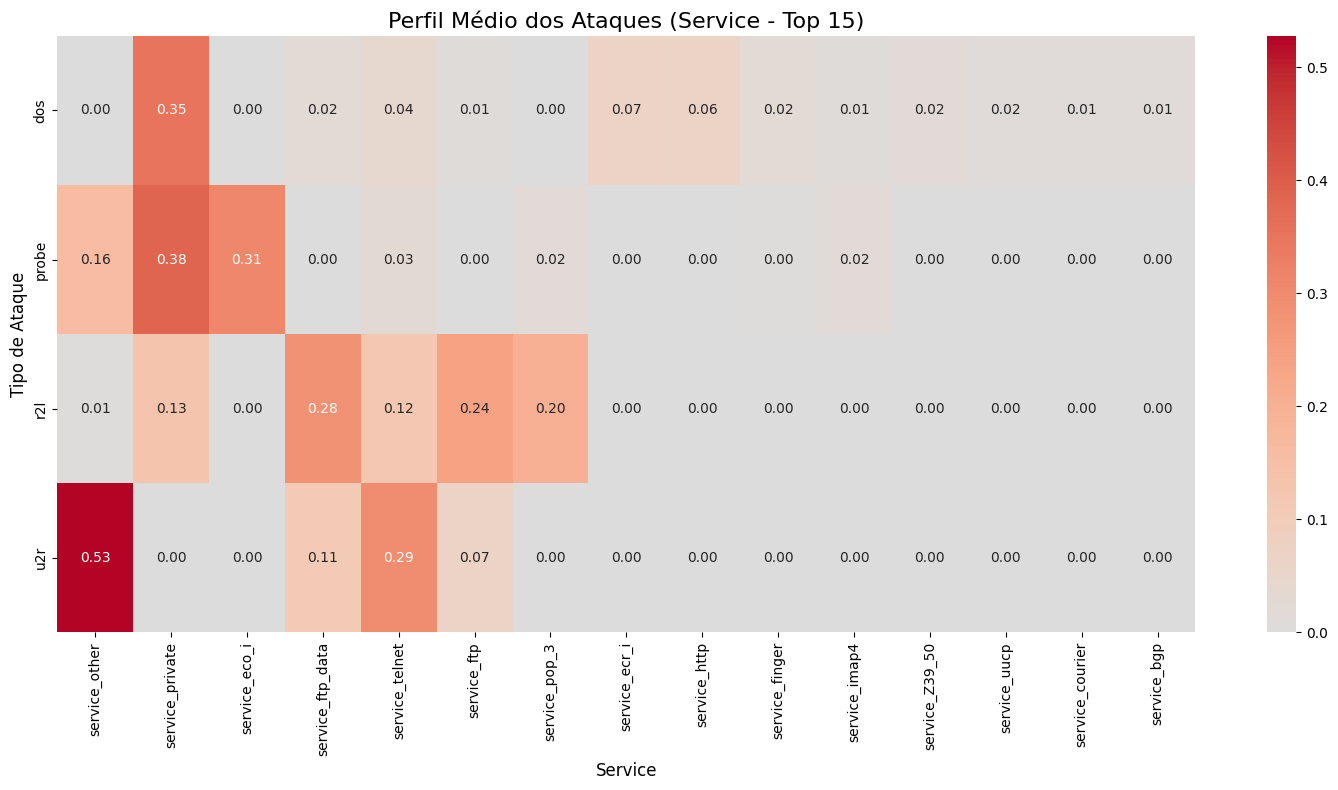

In [ ]:
# --- Heatmap 4: Service (Top 15 por Variância) ---

service_variance = heatmap_data_attacks_only[cols_service].var(axis=0)
top_15_services = service_variance.sort_values(ascending=False).head(15).index.tolist()
plt.figure(figsize=(15, 8))
sns.heatmap(
    heatmap_data_attacks_only[top_15_services], # Filtra para os Top 15 services
    annot=True, fmt='.2f', cmap='coolwarm', center=0, annot_kws={"size": 10}
)
plt.title('Perfil Médio dos Ataques (Service - Top 15)', fontsize=16)
plt.xlabel('Service', fontsize=12)
plt.ylabel('Tipo de Ataque', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

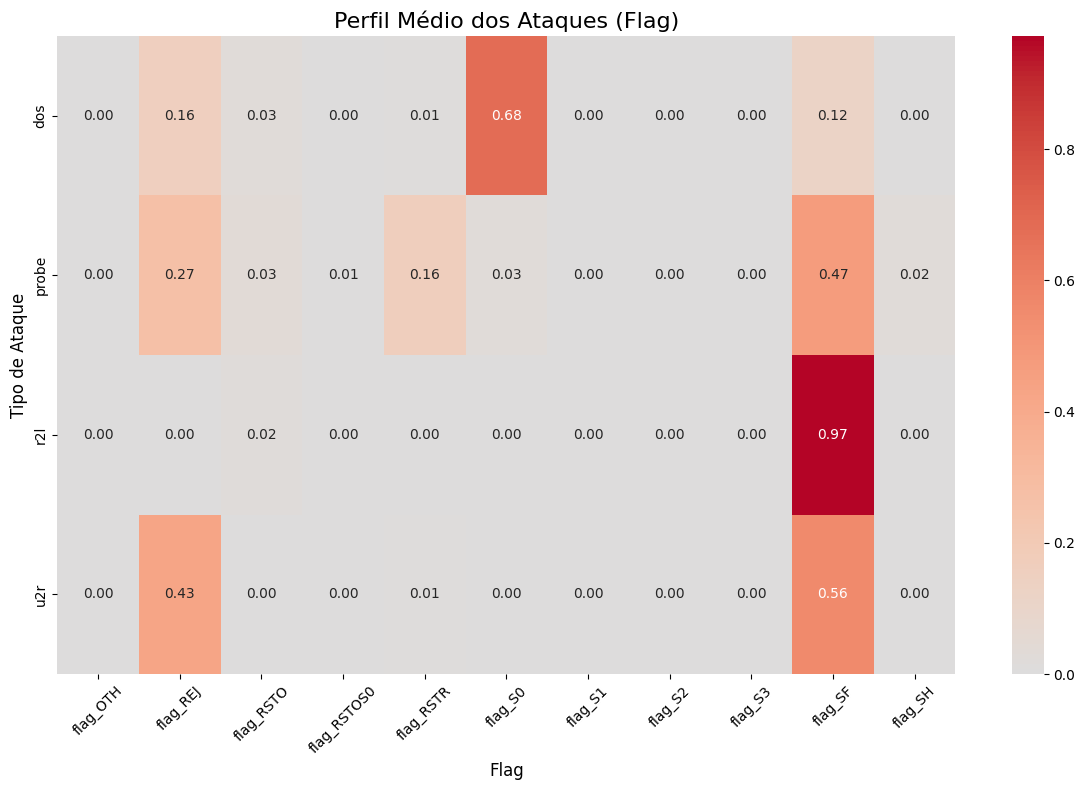

In [ ]:
# --- Heatmap 5: Dummies de Flag ---

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data_attacks_only[cols_flag], # Filtra para as dummies de flag
    annot=True, fmt='.2f', cmap='coolwarm', center=0, annot_kws={"size": 10}
)
plt.title('Perfil Médio dos Ataques (Flag)', fontsize=16)
plt.xlabel('Flag', fontsize=12)
plt.ylabel('Tipo de Ataque', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Treino do Modelo

In [ ]:
# ----- Tratamento dos dados: One-Hot Encoding -----

# Juntamos treino e teste para garantir que o OHE crie as mesmas colunas para ambos os datasets
combined_df = pd.concat([df_train_raw, df_test_raw], ignore_index=True)
categorical_cols = ['protocol_type', 'service', 'flag']

print(f"Shape antes do One-Hot Encoding: {combined_df.shape}")

# Aplicação do get_dummies para as colunas categóricas
combined_df_processed = pd.get_dummies(combined_df, columns=categorical_cols)

print(f"Shape depois do One-Hot Encoding: {combined_df_processed.shape}")

Shape antes do One-Hot Encoding: (148517, 44)
Shape depois do One-Hot Encoding: (148517, 125)


In [ ]:
# ----- Separação dos DataFrames de Treino e Teste e de x e y

train_processed = combined_df_processed.iloc[:len(df_train_raw)]
test_processed = combined_df_processed.iloc[:len(df_test_raw)]

# Colunas para eliminar
labels_to_drop = ['label', 'difficulty', 'attack_type']

# Guardando os rótulos que criamos
y_train = train_processed['attack_type']
y_test = test_processed['attack_type']

# Criação dos DataFrames apenas com as features
X_train_numeric = train_processed.drop(columns=labels_to_drop)
X_test_numeric = test_processed.drop(columns=labels_to_drop)

# Guardando a lista de nomes de features finais para posterior identificação
feature_names = X_train_numeric.columns.tolist()

print(f"Shape do X_train: {X_train_numeric.shape} | Shape do y_train: {y_train.shape}")
print(f"Shape do X_test: {X_test_numeric.shape} | Shape do y_test: {y_test.shape}")

Shape do X_train: (125973, 122) | Shape do y_train: (125973,)
Shape do X_test: (22544, 122) | Shape do y_test: (22544,)


In [ ]:
# ----- Tratamento dos dados: StandardScaler -----

scaler = StandardScaler()

# Separação das amostras categorizadas como normais
train_normal_only = X_train_numeric[y_train == 'normal']

# Treino do scaler apenas com as amostras normais, uma vez que serão a nossa base
# de comparação com as outras amostras
scaler.fit(train_normal_only)

# Aplicação do scaler em todos os dados (treino e teste)
# Dessa forma, os números serão uma comparação com o "normal"
X_train_scaled_data = scaler.transform(X_train_numeric)
X_test_scaled_data = scaler.transform(X_test_numeric)

# Reconstrução dos DataFrames com os nomes das colunas
X_train_scaled = pd.DataFrame(X_train_scaled_data, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled_data, columns=feature_names)

X_train_scaled.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.129241,-0.030237,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,-0.204096,-0.057119,0.000000,-0.046612,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450
1,-0.129241,-0.031062,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,-0.204096,-0.057119,0.000000,-0.046612,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450
2,-0.129241,-0.031411,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,-0.204096,-0.057119,0.000000,-0.046612,13.756252,-0.073413,-0.042074,-0.025859,-4.006103,-0.005450
3,-0.129241,-0.030856,0.058405,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,0.638100,-0.015487,...,-0.204096,-0.057119,0.000000,-0.046612,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450
4,-0.129241,-0.030935,-0.059724,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,0.638100,-0.015487,...,-0.204096,-0.057119,0.000000,-0.046612,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450


# Usando os Pesos do Heatmap

Abaixo nós estamos criando o heatmap apenas com os dados de treino, mas o processo é o mesmo.

Usando os resultados desse heatmap, podemos selecionar uma quantidade de features com a maior relevância para caracterizar cada ataque e criar os atributos que vão auxiliar nosso modelo a fazer as previsões: `dos_risk_score`, `probe_risk_score`, `r2l_risk_score` e `u2r_risk_score`, que vão conter um valor que é mais alto ou mais baixo a depender da probabilidade da amostra em questão poder ser classificada como um desses ataques. Pelos meus testes, a quantidade de features que apresentou os melhores resultados foi 7, então vamos considerar essa quantidade e conferir quais features nós obtivemos com essa análise:


In [ ]:
# ----- Geração dos pesos para o heatmap (Para os Scores) -----

temp_heatmap_df = X_train_scaled.copy()
temp_heatmap_df['attack_type'] = y_train.values # Adiciona rótulos temporariamente
heatmap_weights = temp_heatmap_df.groupby('attack_type').mean() # Tira a média para cada coluna de todos os attack_type
# Atenção: nessa linha acima, o 'attack_type' vira índice no heatmap_weights por causa do groupby

# Seleção das features mais importantes
attack_heatmap_data = heatmap_weights.drop('normal') # Aqui o foco são os ataques
attack_heatmap_abs = attack_heatmap_data.abs() # Para que valores positivos e negativos sejam considerados igualmente
top_features_weights = {} # Vamos guardar nesse dicionário, para cada ataque, as features com o maior peso e o seu peso
N_TOP_FEATURES = 7

# Lembre-se de que aqui não estamos lidando com várias amostras, apenas de cada ataque, a média para cada coluna
for attack_type, abs_row_data in attack_heatmap_abs.iterrows(): # Iterrows pega (índice, dados da linha)
    # Ordena os dados da linha do maior pro menor valor, pega apenas a quantidade em N_TOP_FEATURES
    # e guarda seus indexes, que são os nomes das colunas
    top_features_names = abs_row_data.sort_values(ascending=False).head(N_TOP_FEATURES).index
    # Busca os valores originais (com positivos e negativos corretos), criando uma série com índice e valor
    original_values = heatmap_weights.loc[attack_type, top_features_names]
    # Adiciona uma lista de tuplas ao nosso dicionário de ataques, features e pesos
    top_features_weights[attack_type] = list(original_values.items())

    print(f"\nTop {N_TOP_FEATURES} features escolhidas para '{attack_type}_risk_score':")
    for feature, weight in top_features_weights[attack_type]:
        print(f"  - {feature} (Peso/Z-Score: {weight:.4f})")


Top 7 features escolhidas para 'dos_risk_score':
  - dst_host_srv_serror_rate (Peso/Z-Score: 13.0162)
  - flag_S0 (Peso/Z-Score: 10.2685)
  - srv_serror_rate (Peso/Z-Score: 8.4998)
  - dst_host_serror_rate (Peso/Z-Score: 7.9777)
  - serror_rate (Peso/Z-Score: 7.8022)
  - same_srv_rate (Peso/Z-Score: -5.3853)
  - flag_SF (Peso/Z-Score: -3.5799)

Top 7 features escolhidas para 'probe_risk_score':
  - flag_SH (Peso/Z-Score: 4.1665)
  - service_eco_i (Peso/Z-Score: 4.0125)
  - flag_RSTR (Peso/Z-Score: 3.9745)
  - service_private (Peso/Z-Score: 3.3853)
  - dst_host_diff_srv_rate (Peso/Z-Score: 2.8097)
  - dst_bytes (Peso/Z-Score: 2.7000)
  - protocol_type_icmp (Peso/Z-Score: 2.4288)

Top 7 features escolhidas para 'r2l_risk_score':
  - hot (Peso/Z-Score: 3.5108)
  - is_guest_login (Peso/Z-Score: 2.6664)
  - service_ftp (Peso/Z-Score: 2.5866)
  - service_ftp_data (Peso/Z-Score: 2.0361)
  - dst_host_same_src_port_rate (Peso/Z-Score: 1.8680)
  - service_imap4 (Peso/Z-Score: 1.6497)
  - dst_ho

# Cálculo do Risk Score

Vamos entender o cálculo do Risk Score usando uma amostra Z como exemplo. Para essa amostra, iremos calcular seu dos_risk_score.
Primeiro, dela separamos as 7 features de maior relevância identificadas pelo heatmap e obtemos seus valores:

* `dst_host_srv_serror_rate` = 17.521678
* `flag_S0` = 13.756252
* `srv_serror_rate` = 11.430875
* `dst_host_serror_rate` = 10.717485
* `serror_rate` = 10.471827
* `same_srv_rate` = -6.368096
* `flag_SF` = -4.006103

> Lembrando que criamos dummies das features categóricas, então a features como “`flag`” foram quebradas em “`flag_S0`”, “`flag_S1`”, “`flag_S2`”, etc.

Depois, multiplicamos cada valor pelo seu respectivo peso encontrado no heatmap. Exemplo:
* `dst_host_srv_serror_rate` da amostra Z × peso de `dst_host_srv_serror_rate` (no heatmap)
* 17.521678 x 13.0162 = 228.0656651836

Fazemos o mesmo para as outras:
* `flag_S0` = 13.756252 x 10.2685 = 141.256073662
* `srv_serror_rate` = 11.430875 x 8.4998 = 97.160151325
* `dst_host_serror_rate` = 10.717485 x 7.9777 = 85.5008800845
* `serror_rate` = 10.471827 x 7.8022 = 81.7032886194
* `same_srv_rate` = -6.368096 x -5.3853 = 34.2941073888
* `flag_SF` = -4.006103 x -3.5799 = 14.3414481297

Ao fim, somamos todos os resultados:
> 228.0656651836 + 141.256073662 + 97.160151325 + 85.5008800845 + 81.7032886194 + 34.2941073888 + 14.3414481297 = 682.321614393

O `dos_risk_score` para a amostra Y é igual a 682.321614393. Um valor extremamente alto, que deve indicar ao modelo que essa amostra corresponde a um ataque de DoS, principalmente se os outros scores forem relativamente baixos. Para calculá-los, se faz o mesmo processo, mas para suas respectivas features mais importantes.


In [ ]:
# ----- Aplicação dos pesos para criar o dataset final (com os scores) -----

final_X_train = X_train_scaled.copy()
final_X_test = X_test_scaled.copy()

for attack_type, weights_list in top_features_weights.items():
    score_col_name = f"{attack_type}_risk_score" # Define o nome da coluna que estamos criando
    final_X_train[score_col_name] = 0.0 # Inicializa o valor da célula
    final_X_test[score_col_name] = 0.0
    for feature, weight in weights_list:
        final_X_train[score_col_name] += final_X_train[feature] * weight # Calcula o score para aquela amostra
        final_X_test[score_col_name] += final_X_test[feature] * weight

# As novas features criadas podem ser visualizadas no final
final_X_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,dos_risk_score,probe_risk_score,r2l_risk_score,u2r_risk_score
0,-0.129241,-0.030237,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450,-7.695909,-1.707827,9.434563,3.798372
1,-0.129241,-0.031062,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450,26.622027,10.752759,7.284368,9.202769
2,-0.129241,-0.031411,-0.066140,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,-1.567153,-0.015487,...,13.756252,-0.073413,-0.042074,-0.025859,-4.006103,-0.005450,682.321224,26.970057,0.391147,2.604205
3,-0.129241,-0.030856,0.058405,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,0.638100,-0.015487,...,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450,33.432998,-2.027382,-3.336299,-4.304683
4,-0.129241,-0.030935,-0.059724,-0.010196,0.000000,-0.008617,-0.099923,-0.027910,0.638100,-0.015487,...,-0.072694,-0.073413,-0.042074,-0.025859,0.249619,-0.005450,-7.695909,-2.346325,-3.556603,-4.511707


Distribuição de Classes depois do Undersampling:
Counter({'dos': 52, 'normal': 52, 'probe': 52, 'r2l': 52, 'u2r': 52})

----- Resultado com Undersampler + RandomForest -----
------------------------------------------------------------------
              precision    recall  f1-score   support

         dos       0.99      0.97      0.98      8271
      normal       0.98      0.91      0.95     12042
       probe       0.86      0.97      0.91      2037
         r2l       0.26      0.93      0.40       183
         u2r       0.03      1.00      0.06        11

    accuracy                           0.94     22544
   macro avg       0.63      0.96      0.66     22544
weighted avg       0.97      0.94      0.95     22544



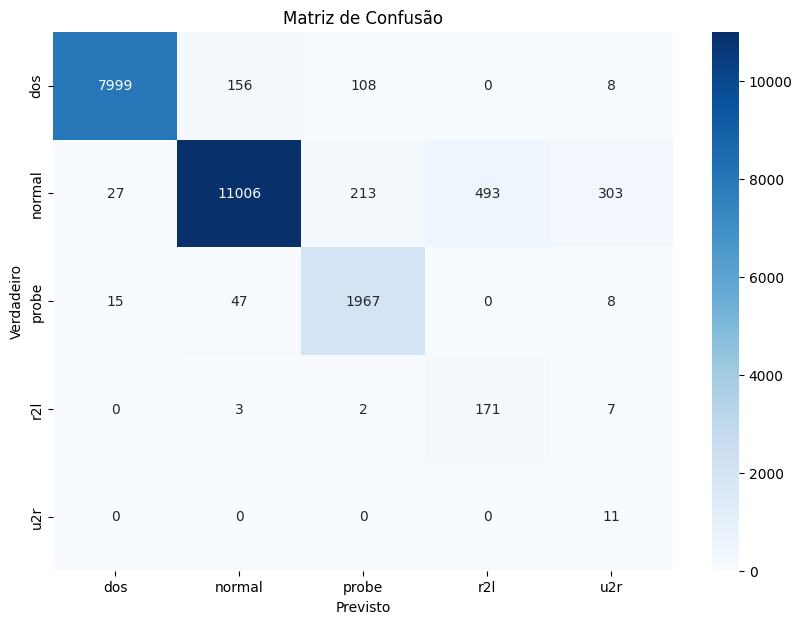

In [ ]:
# ----- Treinamento com Undersampling + RandomForest -----

# 'auto' = reduz tudo, exceto a classe minoritária.
rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')

# Aplicação do Undersampler
X_train_sampled, y_train_sampled = rus.fit_resample(final_X_train, y_train)

print("Distribuição de Classes depois do Undersampling:")
print(Counter(y_train_sampled))

# Treinamento do modelo RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train_sampled, y_train_sampled)

# Previsões no conjunto de teste
y_pred_test = model.predict(final_X_test)

print("\n----- Resultado com Undersampler + RandomForest -----")
print("-"*66)
print(classification_report(y_test, y_pred_test, zero_division=0))

labels_order = model.classes_
cm_test = confusion_matrix(y_test, y_pred_test, labels=labels_order)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=labels_order, yticklabels=labels_order, cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

# Olhando para os resultados do Undersampling + RandomForest

Considerando que esse modelo que estamos buscando treinar poderia ser integrado a um SIEM (Security Information and Event Management), queremos que ele seja capaz de identificar o máximo de ataques possível, assim os profissionais de segurança podem percebê-los e lidar com eles rapidamente. Para verificar se nosso modelo está fazendo isso, olhamos para o **recall**.

> **Recall** é uma métrica que mede a capacidade de um modelo de encontrar todas as instâncias relevantes, respondendo à pergunta: "De todos os casos positivos reais, quantos o modelo identificou corretamente?".

Entretanto, também é importante que ele identifique os ataques *corretamente*, porque não seria interessante se a todo momento surgisse um alerta a ser investigado. Para garantir isso, olhamos para a **precisão**.

> **Precisão** é uma métrica que mede a exatidão das previsões positivas de um modelo, calculada como a razão de verdadeiros positivos para todas as previsões positivas (verdadeiros positivos mais falsos positivos). Ela responde à pergunta: "De todas as instâncias que o modelo previu como positivas, quantas estavam realmente corretas?".

O resultado do modelo acima teve um ótimo recall. Ele até conseguiu acertar todos ataques u2r! Mas em contrapartida, chutou centenas de movimentações como u2r, quando eram na verdade, apenas tráfego normal.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4336
[LightGBM] [Info] Number of data points in the train set: 125973, number of used features: 114
[LightGBM] [Info] Start training from score -1.009014
[LightGBM] [Info] Start training from score -0.626269
[LightGBM] [Info] Start training from score -2.380247
[LightGBM] [Info] Start training from score -4.841080
[LightGBM] [Info] Start training from score -7.792579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

----- Resultado com LGBM -----
------------------------------------------------------------------
              precision    recall  f1-score   support

         dos       0.99      0.99      0.99      8271
      normal       0.99      0.99      0.99     12042
       probe       0.98      0.99     

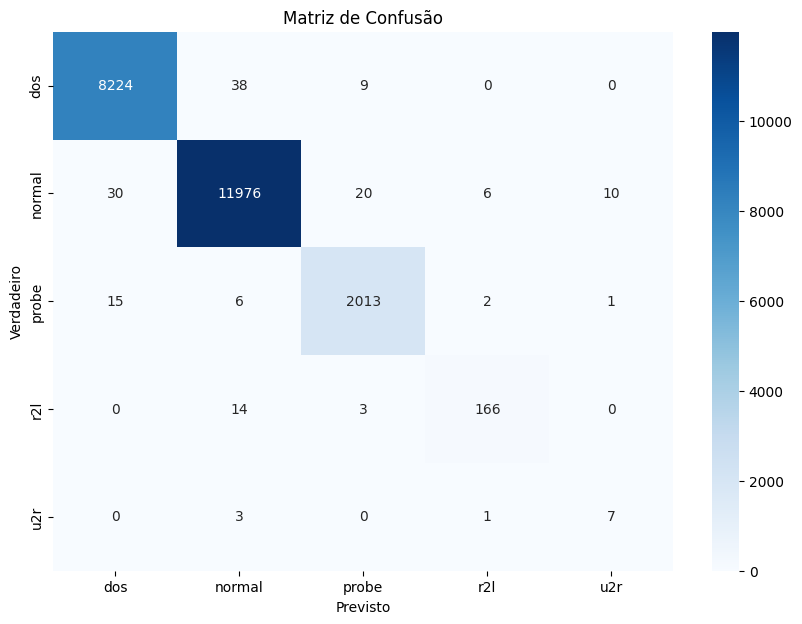

In [ ]:
# ----- Treinamento com LGBM (sem Undersampling) -----

# is_unbalance=True diz ao LGBM para "prestar mais atenção" nas classes minoritárias durante o treino.
model_lgbm = lgb.LGBMClassifier(is_unbalance=True, random_state=42, n_jobs=-1)

# Treino
model_lgbm.fit(final_X_train, y_train)

# Previsões
y_pred_lgbm = model_lgbm.predict(final_X_test)

print("\n----- Resultado com LGBM -----")
print("-"*66)
print(classification_report(y_test, y_pred_lgbm, zero_division=0))

labels_order = model_lgbm.classes_
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm, labels=labels_order)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_lgbm, annot=True, fmt='d', xticklabels=labels_order, yticklabels=labels_order, cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

# Agora, os resultados do LGBM

Após alguns testes, treinar o modelo com LGBM (sem fazer undersampling) trouxe os melhores resultados. A precisão e o recall foram significativamente mais baixos para o U2R em relação aos outros ataques, mas era o esperado de uma base de dados tão desbalanceada, e continua sendo um resultado muito bom em comparação a outros testes. E também notório o bom resultado para o R2L, que também tinha menos dados disponíveis, mas acabou tendo um ótimo desempenho nesse teste.

# Avaliando o Impacto do nosso Feature Engineering

Abaixo, temos uma análise de quais features o nosso modelo de melhor performance (LGBM) considerou as mais relevantes. Olhando especialmente para as que criamos, temos:

*   `probe_risk_score` em **4º** lugar
*   `r2l_risk_score` em **5º** lugar
*   `u2r_risk_score` em **7º** lugar
*   `dos_risk_score` em **11º** lugar

Isso demonstra o quanto as features que criamos influenciaram no bom resultado alcançado.


/tmp/ipython-input-4040633979.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


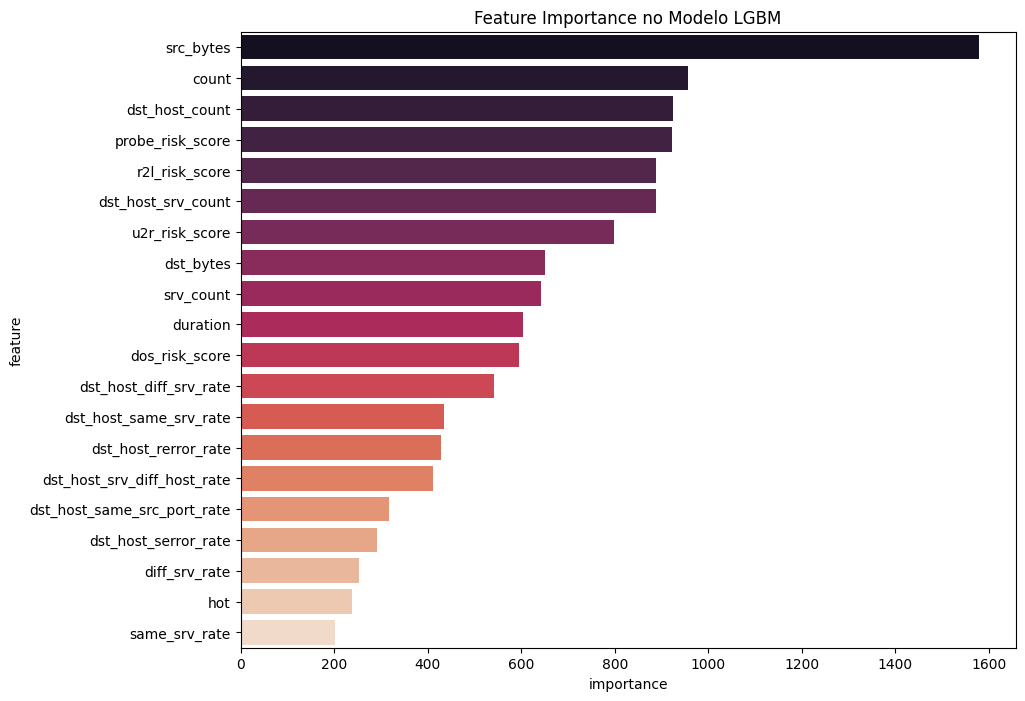

                feature  importance
1             src_bytes        1578
19                count         957
28       dst_host_count         924
123    probe_risk_score         922
124      r2l_risk_score         888
29   dst_host_srv_count         887
125      u2r_risk_score         798
2             dst_bytes         650
20            srv_count         642
0              duration         603


In [ ]:
# ----- Verificação de Feature Importance -----

feature_importance_df = pd.DataFrame({
    'feature': final_X_train.columns,
    'importance': model_lgbm.feature_importances_
}).sort_values(by='importance', ascending=False)

# Plotar as 20 features mais importantes
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(20),
    palette='rocket'
)
plt.title('Feature Importance no Modelo LGBM')
plt.show()

print(feature_importance_df.head(10))

# Conclusão

Este estudo foi a tentativa de encontrar a melhor solução “mais simples” para classificar os dados do dataset NSL-KDD, além de oferecer um overview das características de quatro tipos de ataques cibernéticos conhecidos. É importante notar que o NSL-KDD é um dataset antigo, e muitas coisas evoluíram de lá pra cá, então para ter uma visão mais modernizada dos ataques, é importante observar datasets mais recentes que tenham o mesmo propósito.

Podem existir maneiras mais eficazes de melhorar a classificação realizada aqui (por meio do machine learning), como a Classificação Hierárquica. Entretanto, em termos de eficiência, ela pode não ser a maneira ideal de resolver esse problema. Se você testou alguma outra coisa que trouxe melhores resultados, eu gostaria de saber!